In [1]:
from __future__ import print_function, division

import pickle


import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.options.display.max_columns = 40

## Goals of this notebook:

- Data Exploration
    - Outlier Detection
    - Plotting Distributions
- Feature Engineering
    - Interactions Between Features
    - Dimensionality Reduction using PCA
- Feature Selection and Model Building

## Load Data

In [3]:
import pickle
with open('Pre_Processed_IMDB_Data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)
df.head()

,tconst,primaryProfession,mpaa_rating,metacritic_score,averageRating,release,genres,Num_Theaters,Price,runtimeMinutes,release_year,release_season,weighted_score,opening_per_theater,release_1_month_prev,release_6_month_prev,release_12_month_prev,average_star_rank_12_month_1,average_star_rank_12_month_2,average_star_rank_12_month_3,average_star_rank_12_month_4,average_star_rank_12_month_5,average_star_rank_6_month_1,average_star_rank_6_month_2,average_star_rank_6_month_3,average_star_rank_6_month_4,average_star_rank_6_month_5,average_star_rank_1_month_1,average_star_rank_1_month_2,average_star_rank_1_month_3,average_star_rank_1_month_4,average_star_rank_1_month_5,average_star_rank_0_month_1,average_star_rank_0_month_2,average_star_rank_0_month_3,average_star_rank_0_month_4,average_star_rank_0_month_5,release_type
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,tt0365907,producer,R,57,6.5,2014-09-19,Crime,2712,12758780,114.0,2014,summer,6.10,4704.564897,2014-08-20,2014-03-23,2013-09-24,46.0,56.0,171.000000,313.00,1124.8,45.0,55.5,170.666667,312.75,1124.6,45.0,55.5,170.666667,300.75,644.0,34.0,50.0,167.0,260.00,513.4,wide
Pride and Prejudice and Zombies,tt1374989,producer,PG-13,45,5.8,2016-02-05,Action,2931,5324240,108.0,2016,winter,5.15,1816.526783,2016-01-06,2015-08-09,2015-02-10,3.0,34.5,50.666667,68.00,1050.0,1.0,33.5,50.000000,67.50,1049.6,1.0,33.5,50.000000,67.50,379.6,1.0,33.5,50.0,67.50,379.6,wide
Clown,tt1780798,producer,R,42,5.7,2016-06-17,Horror,100,26920,100.0,2016,spring,4.95,269.200000,2016-05-18,2015-12-20,2015-06-23,196.0,208.0,234.333333,366.75,2369.4,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.0,286.25,1919.6,limited
American Made,tt3532216,producer,R,65,7.2,2017-09-29,Action,3024,16776390,115.0,2017,autumn,6.85,5547.748016,2017-08-30,2017-04-02,2016-10-04,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,10.000000,21.00,112.8,3.0,4.5,6.0,18.00,110.4,wide
The Quiet Ones,tt2235779,producer,PG-13,41,5.1,2014-04-25,Horror,2027,3880053,98.0,2014,spring,4.60,1914.185002,2014-03-26,2013-10-27,2013-04-30,98.0,384.5,507.000000,3300.75,6330.2,69.0,236.0,408.000000,1785.75,4426.8,2.0,83.0,306.000000,520.00,1873.6,2.0,83.0,306.0,496.25,1734.0,wide


## Data Exploration

In [4]:
## Plot distributions of each non-dummy variable
var_list = ['metacritic_score', 'averageRating', 'Num_Theaters', 'Price', 'runtimeMinutes', 'release_year', 'weighted_score',
           'average_star_rank_12_month_1', 'average_star_rank_12_month_2', 'average_star_rank_12_month_3', 'average_star_rank_12_month_4', 'average_star_rank_12_month_5']

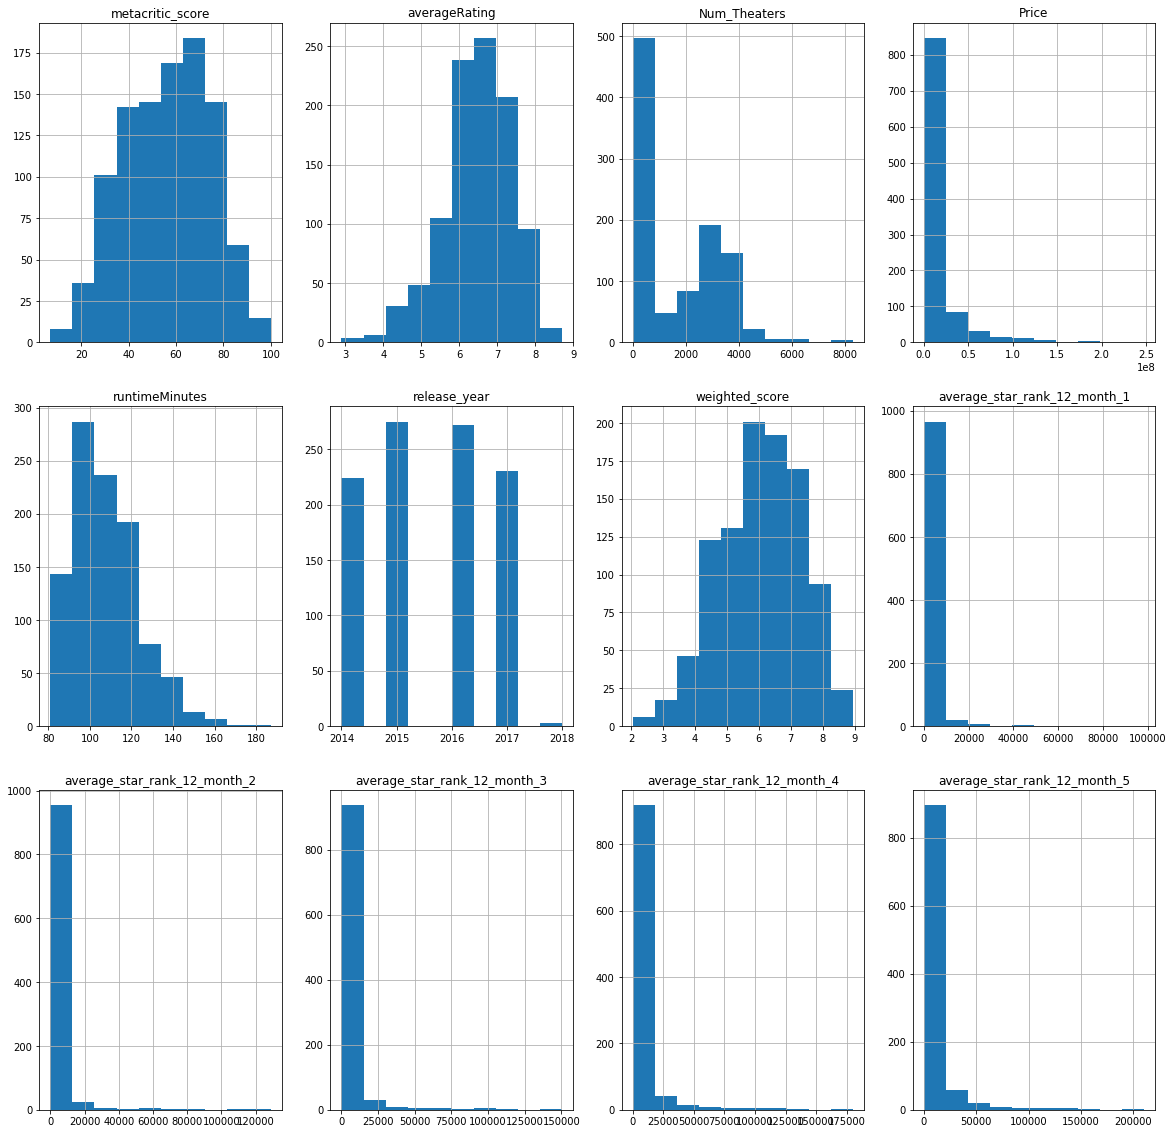

In [5]:
fig, ax = plt.subplots(3,4, figsize=(20,20))
ax = ax.reshape(len(var_list), 1)
for i in range(len(var_list)):
    df[var_list[i]].hist(ax=ax[i][0])
    ax[i][0].set_title(var_list[i])

- **metacritic\_score, averageRating, runtimeMinutes, release\_year, **and** weighted\_score** are all approximately normal distributions
- **average\_star\_rank\_12\_month\_[0-5] **and** Price** are both skewed, but this issue is solved by performing a log transform on the data

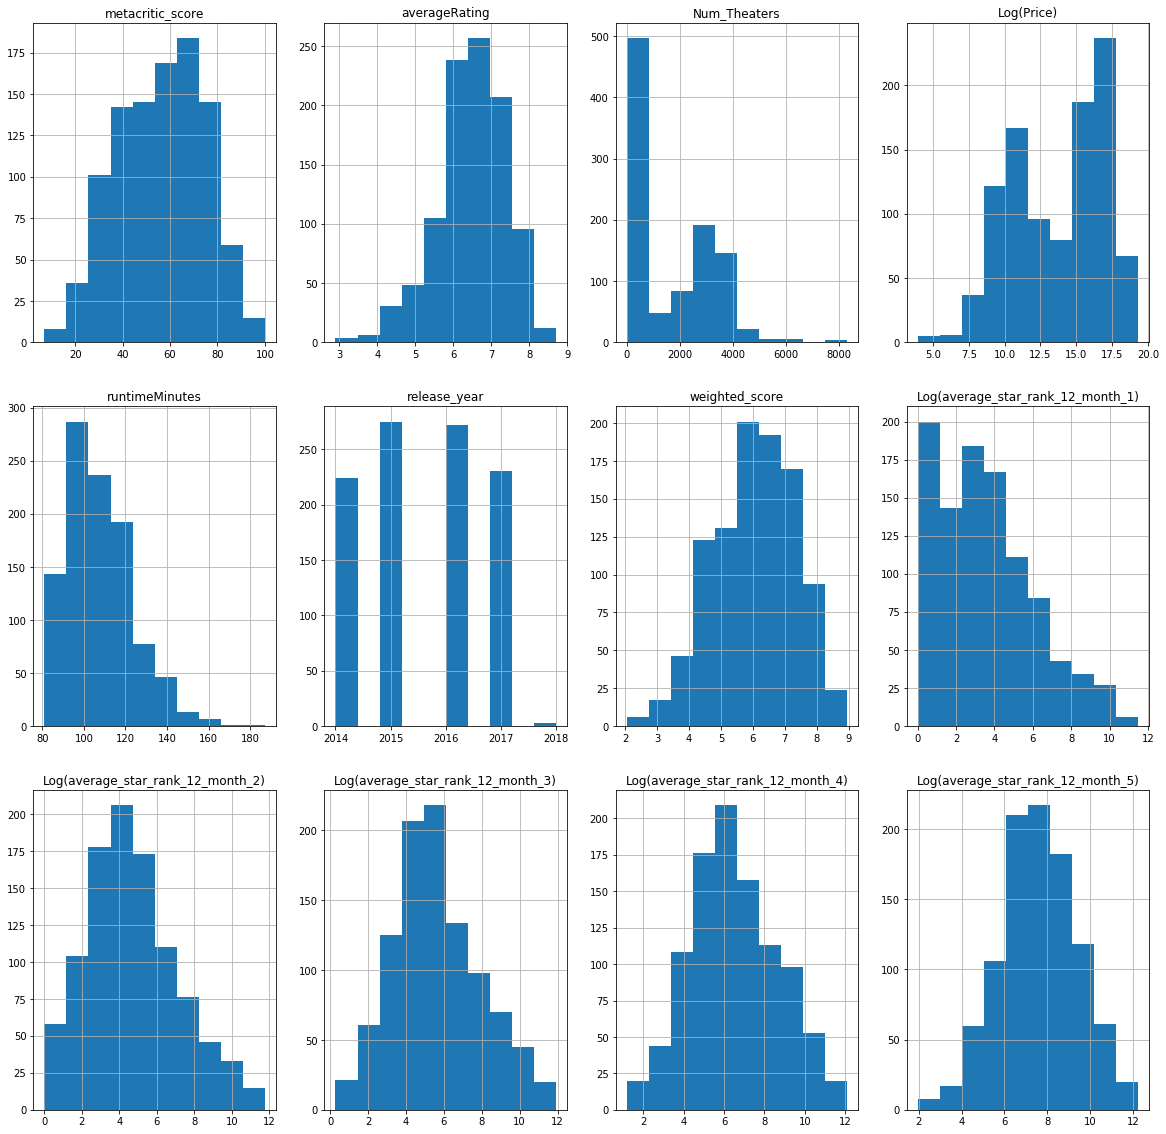

In [6]:
fig, ax = plt.subplots(3,4, figsize=(20,20))
ax = ax.reshape(len(var_list), 1)
for i in range(len(var_list)):
    if ('average_star_rank' in var_list[i]) or (var_list[i] == 'Price'):
        df[var_list[i]].apply(np.log).hist(ax=ax[i][0])
        ax[i][0].set_title('Log('+var_list[i]+')')
    else:
        df[var_list[i]].hist(ax=ax[i][0])
        ax[i][0].set_title(var_list[i])

We can drop **average_star_rank_12_month_1** because it does not follow a normal distribution. **average_star_rank_12_month_5** has the most normal distribution, so we will select this initially as our feature. 

Also, **Log(Price)** appears to have a bimodal distribution, so we should treat each mode separately. We can view the split by comparing limited releases to box office releases:

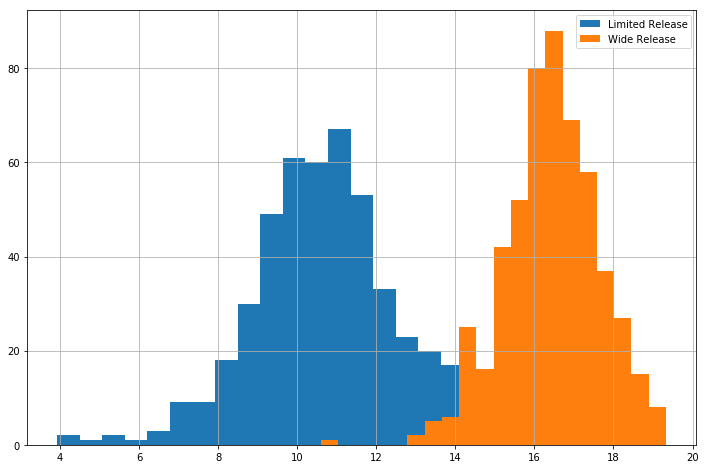

In [7]:
plt.figure(figsize=(12,8))
mask = (df['release_type'] == 'limited')
df[mask]['Price'].apply(np.log).hist(bins=20, label='Limited Release')

mask = (df['release_type'] == 'wide')
df[mask]['Price'].apply(np.log).hist(bins=20, label='Wide Release')

plt.legend();

If we would like to look at all data at once, a better metric would be looking at **opening_per_theater**, which is defined as the total opening weekend box office gross divided by the number of theaters showing the film during opening weekend.

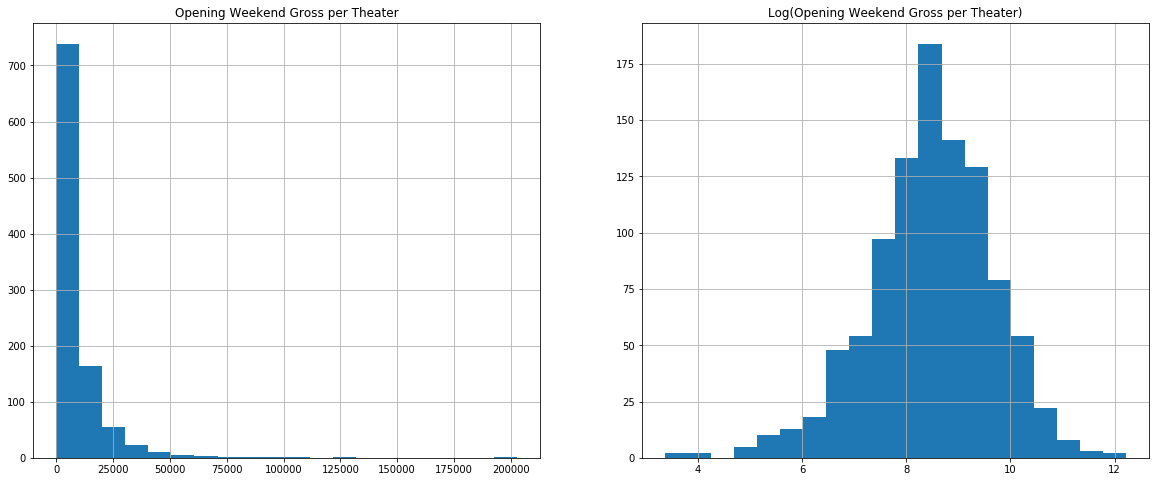

In [8]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
df['opening_per_theater'].hist(bins=20)
plt.title('Opening Weekend Gross per Theater')

plt.subplot(1,2,2)
df['opening_per_theater'].apply(np.log).hist(bins=20)
plt.title('Log(Opening Weekend Gross per Theater)')

#### Exploring Categoricals
- Genre
- Release Season
- MPAA Rating
- Release Type

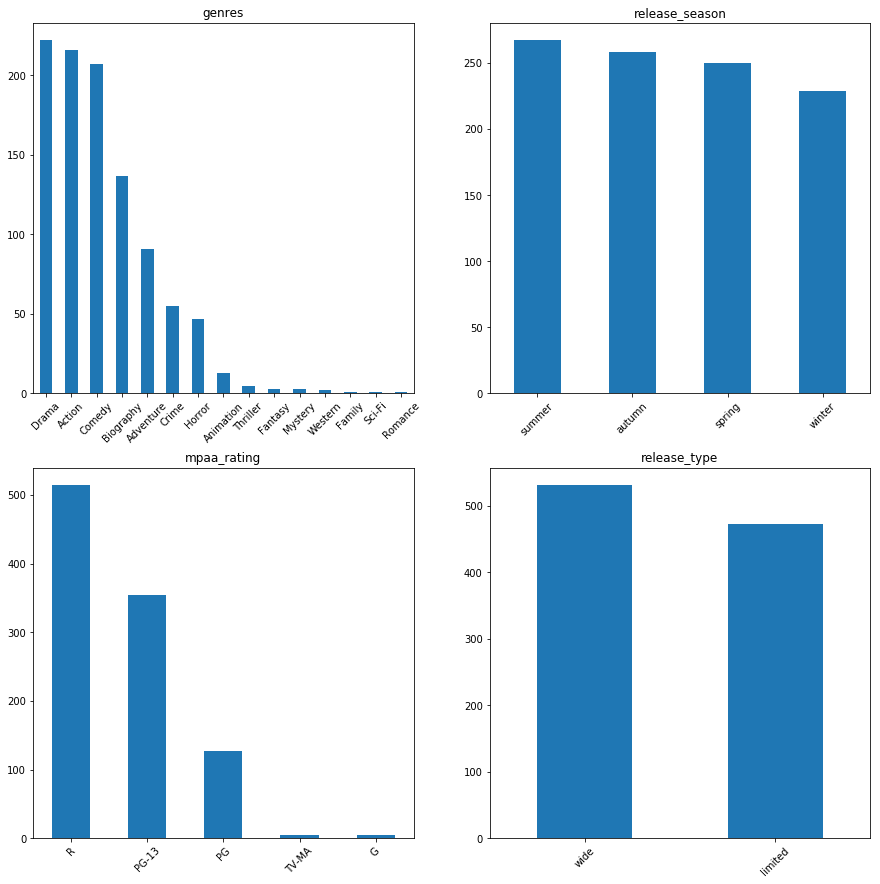

In [9]:
categoricals = ['genres', 'release_season', 'mpaa_rating', 'release_type']
plt.figure(figsize=(15,15))
for i in range(len(categoricals)):
    plt.subplot(2,2,i+1)
    df[categoricals[i]].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title(categoricals[i])

We see a roughly even distribution of data among release seasons and release types (wide vs. limited). However, there's a clear difference in the counts of genres and mpaa_ratings. To account for these, we will do the following:

- Genres will be converted to dummy variables:
    - Drama
    - Action
    - Comedy
    - Biography
    - Adventure
    - Crime
    - Horror
    - Animation
    - Other (incl. Thriller, Mystery, Fantasy, Western, Romance, Sci-Fi, and Family)
- MPAA Ratings will also be converted to dummy variables:
    - R
    - PG-13
    - PG (incl. G)
    - (TV-MA film(s) will be removed, as this is not a typical box-office movie rating)

In [10]:
df['genres_adj'] = [x if x not in ['Thriller', 'Mystery', 'Fantasy', 'Western', 'Romance', 'Sci-Fi', 'Family'] else 'Other' for x in df['genres']]
df[['genres', 'genres_adj']].sample(10, random_state=42)

,genres,genres_adj
title,,
Wild Tales,Comedy,Comedy
The Hollars,Comedy,Comedy
Jinn,Thriller,Other
Hidden Figures,Biography,Biography
Phoenix Forgotten,Horror,Horror
Dirty Grandpa,Comedy,Comedy
Max Steel,Action,Action
Woodshock,Drama,Drama
Central Intelligence,Action,Action


In [11]:
# Convert 'G' to 'PG'
df['mpaa_rating_adj'] = [x if x != 'G' else 'PG' for x in df['mpaa_rating']]

# Remove 'TV-MA' Films
df.drop(list(df[df['mpaa_rating'] == 'TV-MA'].index), inplace=True)

# Print Results
df[['mpaa_rating', 'mpaa_rating_adj']].sort_values('mpaa_rating').head(10)

,mpaa_rating,mpaa_rating_adj
title,,
Cars 3,G,PG
Rio 2,G,PG
The Eagle Huntress,G,PG
The Peanuts Movie,G,PG
Alice Through the Looking Glass,PG,PG
Smurfs: The Lost Village,PG,PG
Sing,PG,PG
Kung Fu Panda 3,PG,PG
The Boss Baby,PG,PG


Now if we re-plot the data:

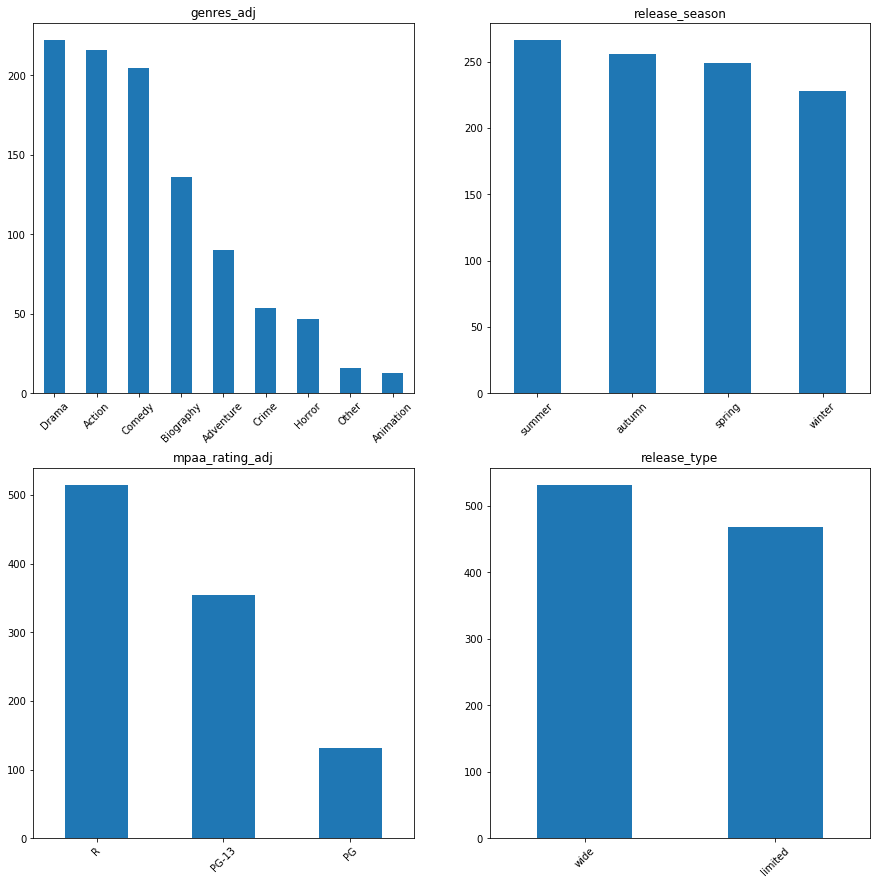

In [12]:
categoricals = ['genres_adj', 'release_season', 'mpaa_rating_adj', 'release_type']
plt.figure(figsize=(15,15))
for i in range(len(categoricals)):
    plt.subplot(2,2,i+1)
    df[categoricals[i]].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title(categoricals[i])

That's better. Let's make some dummy variables!

In [13]:
df_with_dummies = df.join(pd.get_dummies(df['genres_adj'], prefix='dum_is', drop_first=False).iloc[:,:-1])
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['mpaa_rating_adj'], prefix='dum_rated', drop_first=True))
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['release_season'], prefix='dum_release_in', drop_first=True))
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['release_type'], prefix='dum_release', drop_first=False).iloc[:,:-1])
df_with_dummies.drop(['tconst', 'primaryProfession', 'mpaa_rating', 'mpaa_rating_adj', 'metacritic_score', 
                      'averageRating', 'release', 'genres', 'genres_adj', 'release_season', 'release_type'],
                     axis=1, inplace=True)
drop_names = []
for name in df_with_dummies.columns:
    if any(name.endswith(x) for x in ['_1', '_2', '_3', '_4', '_prev']):
        drop_names.append(name)
df_with_dummies.drop(drop_names, axis=1, inplace=True)
df_with_dummies.head()

,Num_Theaters,Price,runtimeMinutes,release_year,weighted_score,opening_per_theater,average_star_rank_12_month_5,average_star_rank_6_month_5,average_star_rank_1_month_5,average_star_rank_0_month_5,dum_is_Action,dum_is_Adventure,dum_is_Animation,dum_is_Biography,dum_is_Comedy,dum_is_Crime,dum_is_Drama,dum_is_Horror,dum_rated_PG-13,dum_rated_R,dum_release_in_spring,dum_release_in_summer,dum_release_in_winter,dum_release_limited
title,,,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,2712,12758780,114.0,2014,6.10,4704.564897,1124.8,1124.6,644.0,513.4,0,0,0,0,0,1,0,0,0,1,0,1,0,0
Pride and Prejudice and Zombies,2931,5324240,108.0,2016,5.15,1816.526783,1050.0,1049.6,379.6,379.6,1,0,0,0,0,0,0,0,1,0,0,0,1,0
Clown,100,26920,100.0,2016,4.95,269.200000,2369.4,2305.0,2305.0,1919.6,0,0,0,0,0,0,0,1,0,1,1,0,0,1
American Made,3024,16776390,115.0,2017,6.85,5547.748016,154.4,154.4,112.8,110.4,1,0,0,0,0,0,0,0,0,1,0,0,0,0
The Quiet Ones,2027,3880053,98.0,2014,4.60,1914.185002,6330.2,4426.8,1873.6,1734.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0


In [14]:
label = ['opening_per_theater', 'Price']
key_feature = ['average_star_rank_12_month_5',
               'average_star_rank_6_month_5',
               'average_star_rank_1_month_5',
               'average_star_rank_0_month_5']
other_features = []
for col in df_with_dummies.columns:
    if col not in label and col not in key_feature:
        other_features.append(col)
        
df_with_dummies.dropna(inplace=True)
df_with_dummies.drop_duplicates(inplace=True)

print("Number of Data Points (m): %d" % len(df_with_dummies))
print("Number of Features    (n): %d" % (len(other_features)+1))

Number of Data Points (m): 994
Number of Features    (n): 19


## Interactions Between Features

First, looking at just the key features (average star rank)

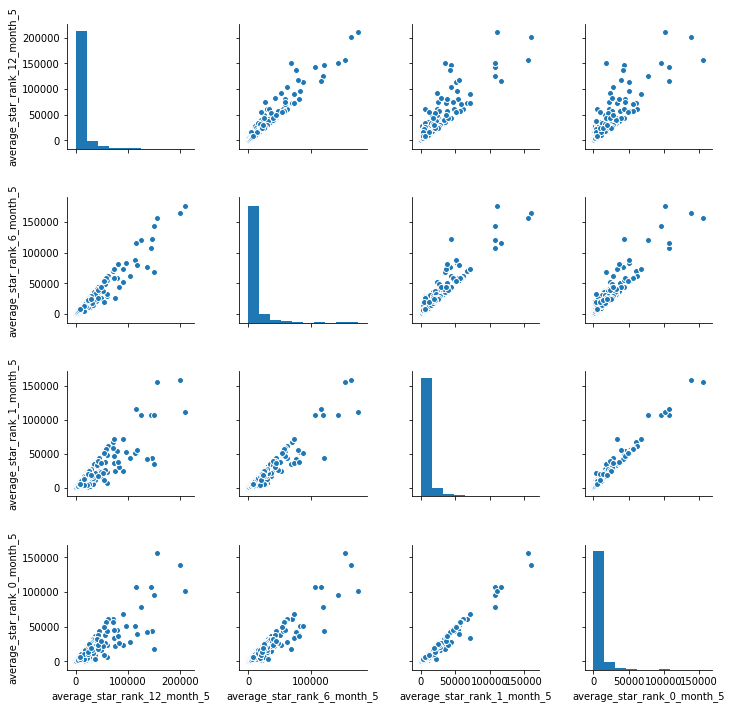

In [15]:
sns.pairplot(df_with_dummies[key_feature])

In [16]:
df_with_dummies[key_feature].corr()

,average_star_rank_12_month_5,average_star_rank_6_month_5,average_star_rank_1_month_5,average_star_rank_0_month_5
average_star_rank_12_month_5,1.000000,0.972910,0.914643,0.898544
average_star_rank_6_month_5,0.972910,1.000000,0.960597,0.947974
average_star_rank_1_month_5,0.914643,0.960597,1.000000,0.988152
average_star_rank_0_month_5,0.898544,0.947974,0.988152,1.000000


Very highly correlated, so we will select only one (**average_star_rank_12_month_5**)

Looking at the other features with this one added in, as well as the first label (**opening_per_theater**):

In [17]:
def log_update_features(df):
    for col_name in df.columns:
        if col_name.startswith('average_star_rank') or (col_name in ['Price', 'opening_per_theater']):
            df[col_name] = df[col_name].apply(np.log)
    return df

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


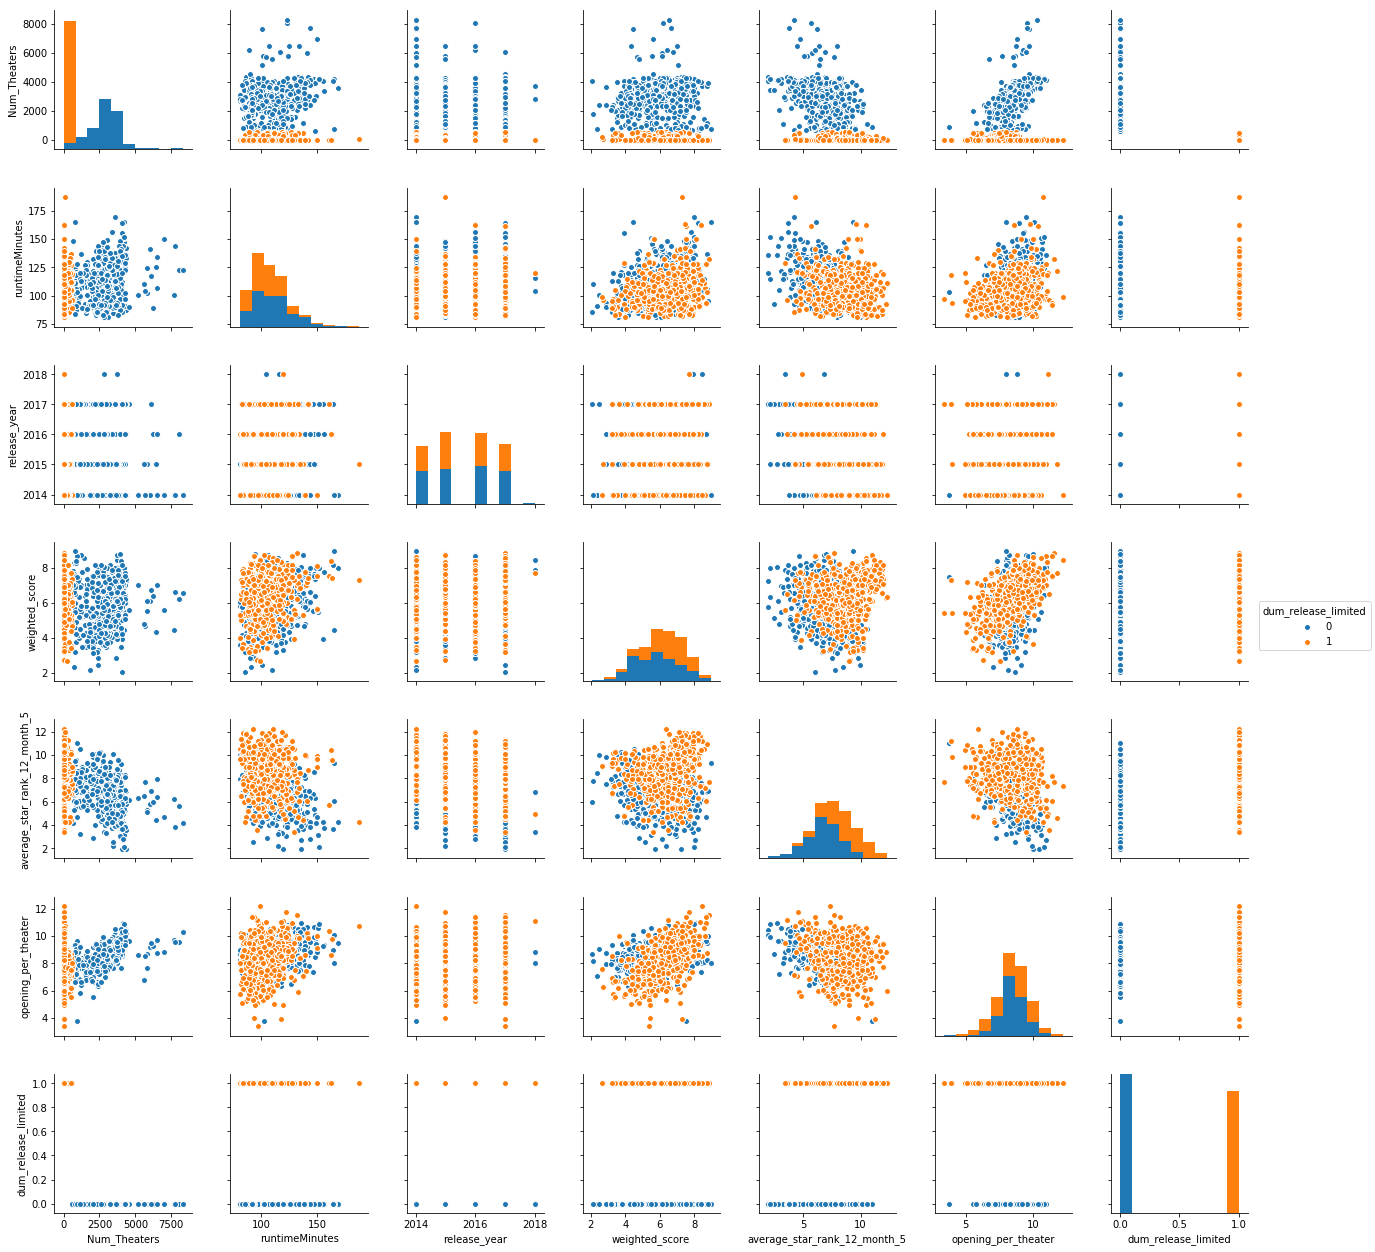

In [18]:
features = other_features + [key_feature[0]] + [label[0]]
non_dummy_features = [f for f in features if f[:3] != 'dum']
sns.pairplot(log_update_features(df_with_dummies[non_dummy_features + ['dum_release_limited']]), hue='dum_release_limited')

In [19]:
X = log_update_features(df_with_dummies[other_features + [key_feature[0]]])
y = log_update_features(pd.DataFrame(df_with_dummies[label[0]]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [20]:
scaler = MinMaxScaler()
scaler.fit(X)
# X = scaler.transform(X)

scaler = MinMaxScaler()
scaler.fit(y)
# y = scaler.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Check Polynomial Degrees to see if it will work.
if True:
    import warnings
    warnings.filterwarnings("ignore")

    from sklearn.metrics import mean_squared_error
    n_degrees = 7

    # Step through degrees from 0 to 9 and store the training and test (generalization) error.
    # create array of zeros,
    train_error = np.empty(n_degrees)
    test_error = np.empty(n_degrees)
    for degree in range(n_degrees):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(X_train, y_train)
        train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
        test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

    # Plot the training and test errors against degree
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(n_degrees), train_error, color='green', label='train')
    plt.plot(np.arange(n_degrees), test_error, color='red', label='test')
    plt.ylim((0.0, 1e0))
    plt.ylabel('log(mean squared error)')
    plt.xlabel('degree')
    plt.legend(loc='upper left')

In [186]:

lr = LinearRegression()

In [187]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [188]:
lr.score(X_train, y_train)

0.30170132460982846

In [189]:
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.31192243474120762

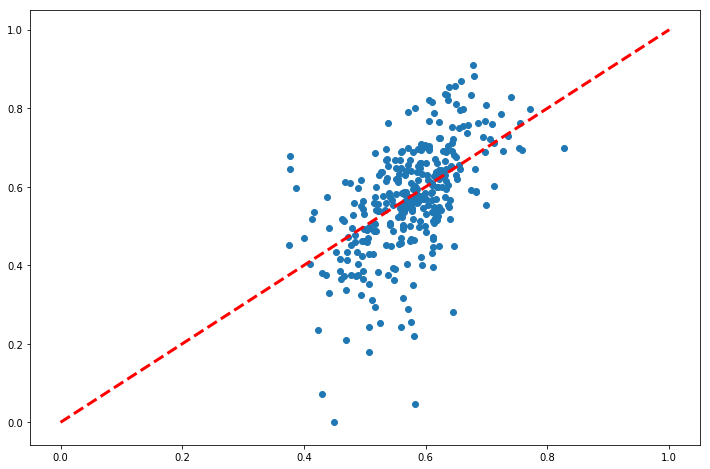

In [190]:
plt.figure(figsize=(12,8))
plt.scatter(y_pred, y_test)
plt.plot([0, 1], [0, 1], 'r--', lw=3)

In [162]:
lr.coef_

array([[  2.81040735e-04,   4.57880085e-03,  -1.36052893e-02,
          3.69604806e-01,   6.41134437e-01,   7.64428773e-01,
          9.28675049e-01,   7.77039987e-01,   7.78704765e-01,
          4.88353148e-01,   6.06249632e-01,   6.61276529e-01,
          1.34829867e-01,  -8.87904589e-02,   2.55355291e-01,
          3.23958026e-01,   1.27885158e-01,   8.06110080e-01,
         -1.00071444e-01]])

In [2]:
import pickle
with open('Pre_Processed_IMDB_Data_with_dummies.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)
df.head()

,tconst,primaryProfession,mpaa_rating,metacritic_score,averageRating,release,genres,Num_Theaters,Price,runtimeMinutes,...,rated_G,rated_PG,rated_PG-13,rated_R,release_in_spring,release_in_summer,release_in_winter,release_limited,log_average_star_rank_12_month_5,log_Price
title,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,tt0365907,producer,R,57,6.5,2014-09-19,Crime,2712,12758780,114.0,...,0,0,0,1,0,1,0,0,7.025361,16.361730
Pride and Prejudice and Zombies,tt1374989,producer,PG-13,45,5.8,2016-02-05,Action,2931,5324240,108.0,...,0,0,1,0,0,0,1,0,6.956545,15.487781
Clown,tt1780798,producer,R,42,5.7,2016-06-17,Horror,100,26920,100.0,...,0,0,0,1,1,0,0,1,7.770392,10.200625
American Made,tt3532216,producer,R,65,7.2,2017-09-29,Action,3024,16776390,115.0,...,0,0,0,1,0,0,0,0,5.039547,16.635483
The Quiet Ones,tt2235779,producer,PG-13,41,5.1,2014-04-25,Horror,2027,3880053,98.0,...,0,0,1,0,1,0,0,0,8.753087,15.171359


In [ ]:
df['log_average_star_rank_12_month_5'] = df['average_star_rank_12_month_5'].apply(np.log)
df['log_Price'] = df['Price'].apply(np.log)

df.dropna(inplace=True)